## Grupo 7: Rubén Gómez y Adrián Sanjuán

# Índice
- [Carga de datos](#cargadedatos)
- [EDA (Análisis exploratorio de datos)](#eda)
  - [Distribución de variables](#distr)
- [Preprocesamiento de los datos](#proc)  
  - [Correlación entre variables](#corr)
  - [Escalado de los datos](#escal)
- [Preparación de datasets finales](#prep)
-[Bibliografía](#bib)

In [ ]:
import numpy as np
from pandas.io.parsers import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.datasets import make_blobs
from scipy import integrate
from sklearn.preprocessing import PolynomialFeatures
from numpy import arange, meshgrid, sqrt
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

Mounted at /content/drive


<a name="cargadedatos"></a>
# Carga de datos

In [ ]:
data = read_csv('/content/drive/MyDrive/AA/PFinal/employee_promotion.csv')

<a name="eda"></a>
# EDA

El objetivo del problema es ayudar al departamento de recursos humanos de una empresa a decidir si un empleado es candidato a ser ascendido o no. Para ello se presenta un dataset con diferentes características de los empleados y si fueron o no ascendidos el año pasado. Las características que se presentan de cada empleado son las siguientes:

* employee_id: ID único del empleado.
* department: Departamento del empleado.
* region: Región de empleo (sin orden específico).
* education: Nivel educativo.
* gender: Género del empleado.
* recruitment_channel: Canal de reclutamiento del empleado.
* no_of_trainings: Número de entrenamientos adicionales completados el año anterior sobre soft-skills, habilidades técnicas, etc.
* age: Edad del empleado.
* previous_year_rating: Calificación del empleado para el año anterior.
* length_ of_ service: Tiempo de servicio en años.
* awards_ won: Si ganó premios durante el año anterior, entonces 1, de lo contrario 0.
* avg_ training_ score: Puntuación promedio en las evaluaciones de entrenamiento actuales.
* is_promoted: (Objetivo) Recomendado para ascenso.



In [ ]:
data['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

Como podemos observar la variable objetivo tiene dos posibles valores (0 si no fue ascendido o 1 si fue ascendido) haciendo del problema uno de clasificación binaria. Otro aspecto a destacar es que las clases están desbalanceadas. Esto último nos lleva a tomar la decisión de que las métricas a utilizar para evaluar el correcto funcionamiento del modelo han de ser la **precisión** y el **recall**. Esto último conduce a la métrica f1 score, la cual es la media armónica de la precisión y el recall.

Desde el punto de vista del empleado es importante detectar correctamente si un empleado es merecedor de un ascenso por lo que se debería prestar especial atención a reducir el número de falsos negativos. Por otro, desde un punto de vista corporativo, es importante reducir el número de falsos positivos para no ascender a empleados no merecedores de ascenso (a una empresa también le interesa reducir el número de falsos negativos para evitar la fuga de talento). Por esta argumentación creemos que no nos tenemos que centrar en una de estas métricas en especial ya que ambos puntos de vista son importantes. Intentaremos reducir los falsos negativos sin elevar demasiado los falsos positivos.

In [ ]:
# Función para describir el dataset
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all')[1:].transpose())
    combined_df = pd.concat([summ, desc], axis=1)
    
    return combined_df
    
summary(data)

data shape: (54808, 13)


,data type,#missing,%missing,#unique,unique,top,freq,mean,std,min,25%,50%,75%,max
employee_id,int64,0,0.000000,54808,NaN,NaN,NaN,39195.830627,22586.581449,1.0,19669.75,39225.5,58730.5,78298.0
department,object,0,0.000000,9,9,Sales & Marketing,16840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,object,0,0.000000,34,34,region_2,12343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,object,2409,4.395344,3,3,Bachelor's,36669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,object,0,0.000000,2,2,m,38496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recruitment_channel,object,0,0.000000,3,3,other,30446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_trainings,int64,0,0.000000,10,NaN,NaN,NaN,1.253011,0.609264,1.0,1.0,1.0,1.0,10.0
age,int64,0,0.000000,41,NaN,NaN,NaN,34.803915,7.660169,20.0,29.0,33.0,39.0,60.0
previous_year_rating,float64,4124,7.524449,5,NaN,NaN,NaN,3.329256,1.259993,1.0,3.0,3.0,4.0,5.0
length_of_service,int64,0,0.000000,35,NaN,NaN,NaN,5.865512,4.265094,1.0,3.0,5.0,7.0,37.0


En esta tabla resumen de los datos podemos observar varias cosas. Lo primero que observamos es que tenemos columnas de tipo categórico (object) y otras numéricas (int y float) lo cual es importante tener en cuenta en el preprocesamiento de los datos. Otra cosa a tener en cuenta para preparar los datos es que hay tres columnas (education, previous_year_rating, avg_training_score) con algunos valores nulos. Por último la tabla nos ayuda a hacernos una idea de la distribución de las variables en el dataset indicando medias, desviación estándar, valores únicos, máximo y mínimos entre otros.

<a name="distr"></a>
## Distribución de variables

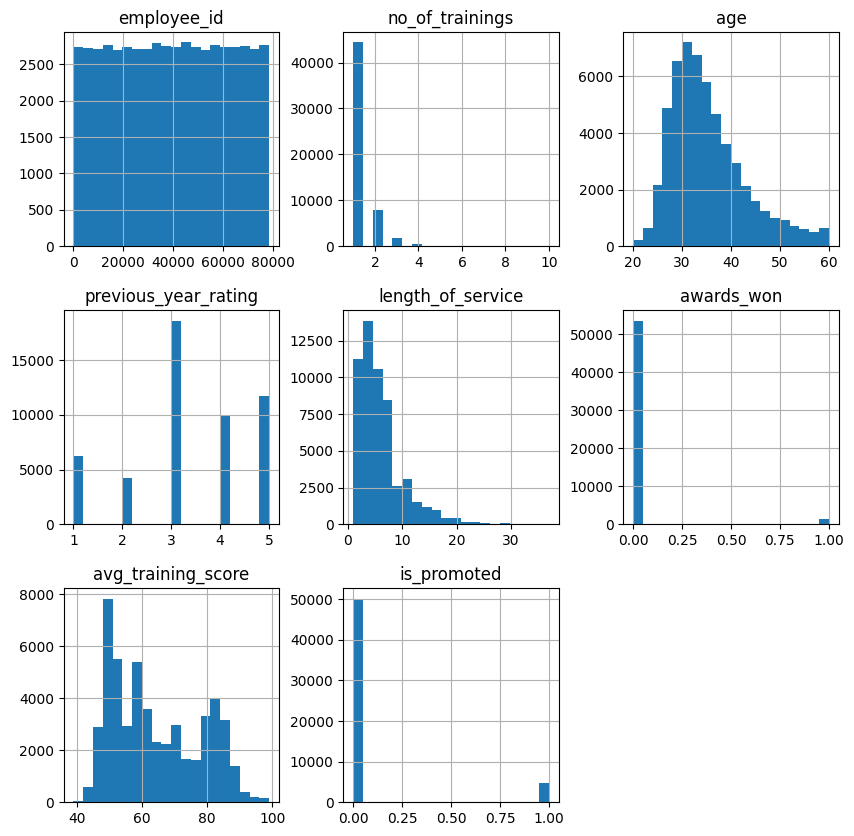

In [ ]:
data.hist(figsize=(10,10),bins = 20)
plt.title("Numeric Features Distribution")
plt.show()

Se puede observar que las variables numéricas se dsitribuyen de distinta manera. Por ejemplo, la variable 'age' tiene una distribución que tiende a una normal, mientras que otras como 'length_of_service' tiene muchos valores cerca del mínimo y va disminuyendo la cantidad a medida que se acerca al máximo. Esta información habrá que tenerla en cuenta a la hora de escalar los datos.

Text(0.5, 1.0, 'Department distribution')

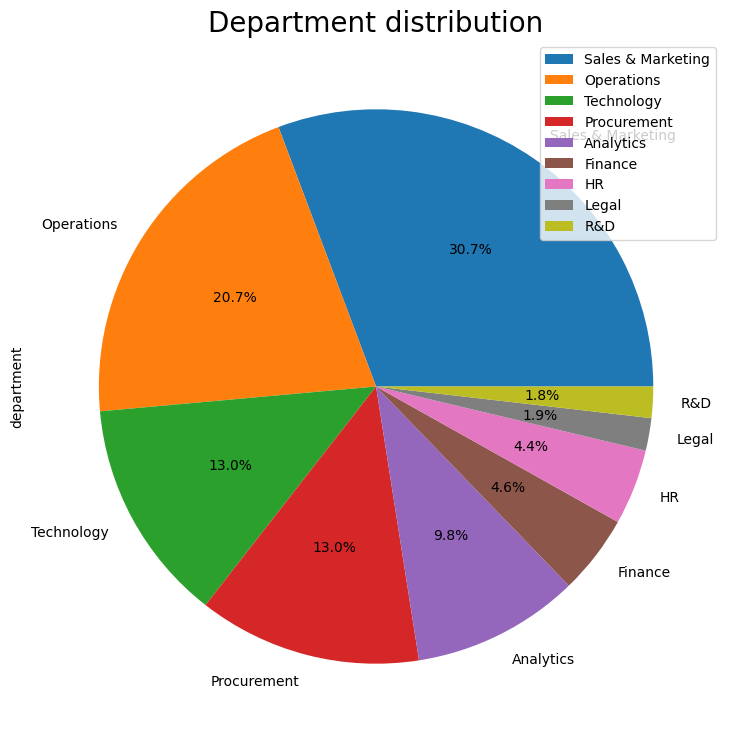

In [ ]:
data["department"].value_counts().plot(kind = 'pie', autopct='%1.1f%%', figsize=(9, 9)).legend()
plt.title('Department distribution', fontsize = 20)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33],
 [Text(0, 0, 'region_2'),
  Text(1, 0, 'region_22'),
  Text(2, 0, 'region_7'),
  Text(3, 0, 'region_15'),
  Text(4, 0, 'region_13'),
  Text(5, 0, 'region_26'),
  Text(6, 0, 'region_31'),
  Text(7, 0, 'region_4'),
  Text(8, 0, 'region_27'),
  Text(9, 0, 'region_16'),
  Text(10, 0, 'region_28'),
  Text(11, 0, 'region_11'),
  Text(12, 0, 'region_23'),
  Text(13, 0, 'region_29'),
  Text(14, 0, 'region_32'),
  Text(15, 0, 'region_19'),
  Text(16, 0, 'region_20'),
  Text(17, 0, 'region_14'),
  Text(18, 0, 'region_25'),
  Text(19, 0, 'region_17'),
  Text(20, 0, 'region_5'),
  Text(21, 0, 'region_6'),
  Text(22, 0, 'region_30'),
  Text(23, 0, 'region_8'),
  Text(24, 0, 'region_10'),
  Text(25, 0, 'region_1'),
  Text(26, 0, 'region_24'),
  Text(27, 0, 'region_12'),
  Text(28, 0, 'region_9'),
  Text(29, 

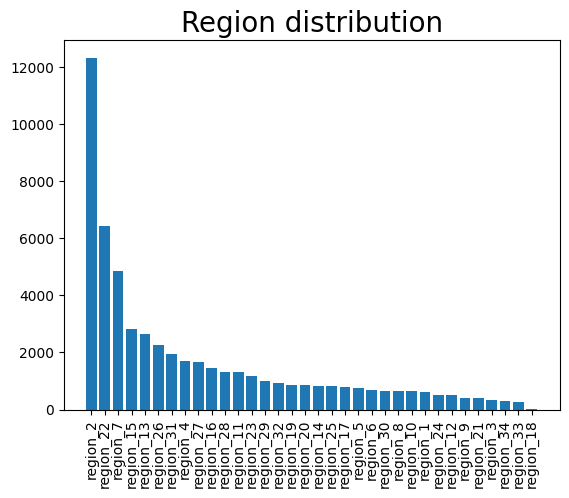

In [ ]:
plt.bar( data.region.value_counts().index, data.region.value_counts())
plt.title('Region distribution', fontsize = 20)
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Education distribution')

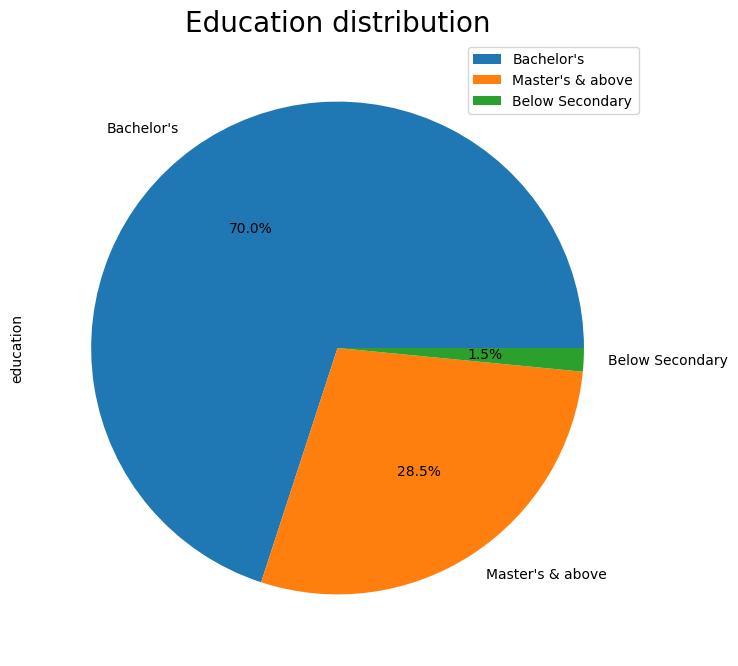

In [ ]:
data["education"].value_counts().head(7).plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8), startangle=0).legend()
plt.title('Education distribution', fontsize = 20)

Text(0.5, 1.0, 'Gender distribution')

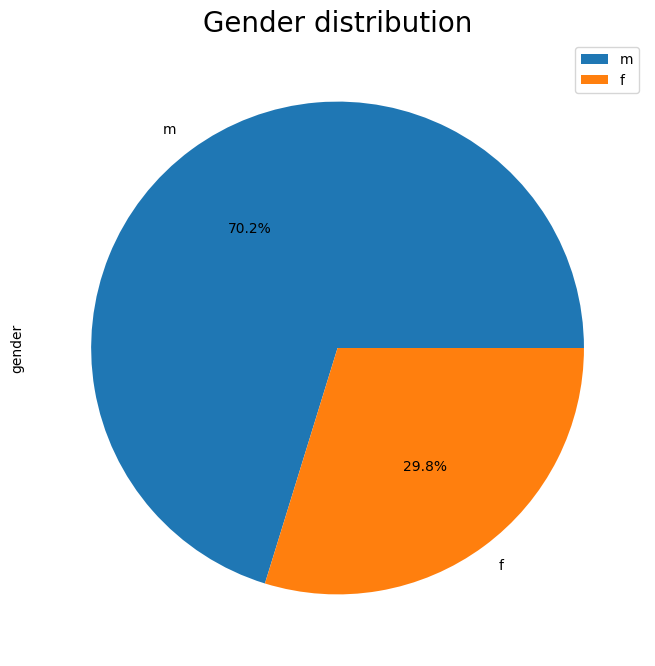

In [ ]:
data["gender"].value_counts().head(7).plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8), startangle=0).legend()
plt.title('Gender distribution', fontsize = 20)

Text(0.5, 1.0, 'Recruitment channel distribution')

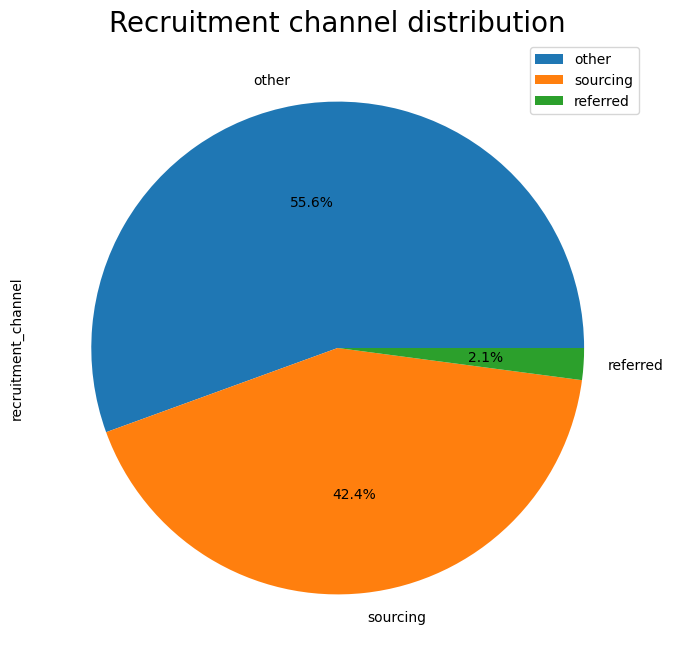

In [ ]:
data["recruitment_channel"].value_counts().head(7).plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8), startangle=0).legend()
plt.title('Recruitment channel distribution', fontsize = 20)

Se puede observar en la distribución de las variables categóricas que no están uniformemente distribuidas. Esto podría llevar a sesgos en el modelo haciendo que predijera mejor (tanto para bien como para mal) para determinadas instancias de las que hay más ejemplos, como es el caso del género donde hay un 70% de hombres y 30% de mujeres.

<a name="proc"></a>
# Preprocesamiento de datos

La primera decisión que tenemos que tomar en el preprocesamiento de los datos es la de qué hacer con los datos nulos. Por el significado de las variables que contienen valores nulos es posible, sobre todo para previous_year_rating y avg_training_score, que se trate de empleados nuevos para los que no existen ese tipo de datos. Una opción sería sustituir estos valores por un valor "con sentido" como la media o la moda. Sin embargo, como ya tenemos una gran cantidad de datos, hemos decidido eliminar estos empleados del dataset. La eliminación de datos no altera demasiado la distribución de la variable objetivo ya que es parecida a la original (ver la siguiente celda).

In [ ]:
data[data.isnull().any(axis=1)]['is_promoted'].value_counts()

0    7831
1     597
Name: is_promoted, dtype: int64

In [ ]:
# Eliminamos instancias con datos nulos
data_pre = data.dropna()
summary(data_pre)['%missing']

data shape: (46380, 13)


employee_id             0.0
department              0.0
region                  0.0
education               0.0
gender                  0.0
recruitment_channel     0.0
no_of_trainings         0.0
age                     0.0
previous_year_rating    0.0
length_of_service       0.0
awards_won              0.0
avg_training_score      0.0
is_promoted             0.0
Name: %missing, dtype: float64

La siguiente decisión a tomar es como procesar las variables categóricas. En general hemos optado por realizar one-hot encoding sobre todas salvo la variable 'education'. En esta última variable, aunque sea categórica, existe una relación de orden entre los posibles valores (según el nivel educativo del empleado) por lo que se va ha codificar con los valores 1, 2 o 3 en función del nivel educativo.

In [ ]:
data_pre['education'].unique()

array(["Master's & above", "Bachelor's", 'Below Secondary'], dtype=object)

In [ ]:
scale_mapper = {'Below Secondary':1, "Bachelor's":2, "Master's & above":3}
data_pre['education'] = data_pre['education'].replace(scale_mapper)

ohe = OneHotEncoder()

categorical_cols = ['department','region','gender','recruitment_channel']
array_hot_encoded = pd.get_dummies(data_pre[categorical_cols])
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=data_pre.index)
data_other_cols = data_pre.drop(columns=categorical_cols)
#Concatenate the two dataframes : 
data_pre = pd.concat([data_other_cols, data_hot_encoded], axis=1)

<ipython-input-16-6bdf90b55030>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pre['education'] = data_pre['education'].replace(scale_mapper)


In [ ]:
print(data_pre.shape)
data_pre

(46380, 57)


,employee_id,education,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted,department_Analytics,...,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,65438,3,1,35,5.0,8,0,49.0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,65141,2,1,30,5.0,4,0,60.0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,7513,2,1,34,3.0,7,0,50.0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,2542,2,2,39,1.0,10,0,50.0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,48945,2,1,45,3.0,2,0,73.0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54802,6915,2,2,31,1.0,2,0,49.0,0,0,...,0,0,0,0,0,0,1,1,0,0
54803,3030,2,1,48,3.0,17,0,78.0,0,0,...,0,0,0,0,0,0,1,0,0,1
54804,74592,3,1,37,2.0,6,0,56.0,0,0,...,0,0,0,0,0,1,0,1,0,0
54805,13918,2,1,27,5.0,3,0,79.0,0,1,...,0,0,0,0,0,0,1,1,0,0


<a name="corr"></a>
## Correlación entre variables

El one-hot encoding a aumentado considerablemente la dimensión del dataset ya que existían algunas variables categóricas con muchos valores únicos como 'region' que tenía 34. Por esta razón es una buena práctica analizar la correlación de las variables entre sí y con la variable objetivo para valorar si podemos descartar alguna (bien porque nos de información redundante o bien porque la información que de sea de poca utilidad).

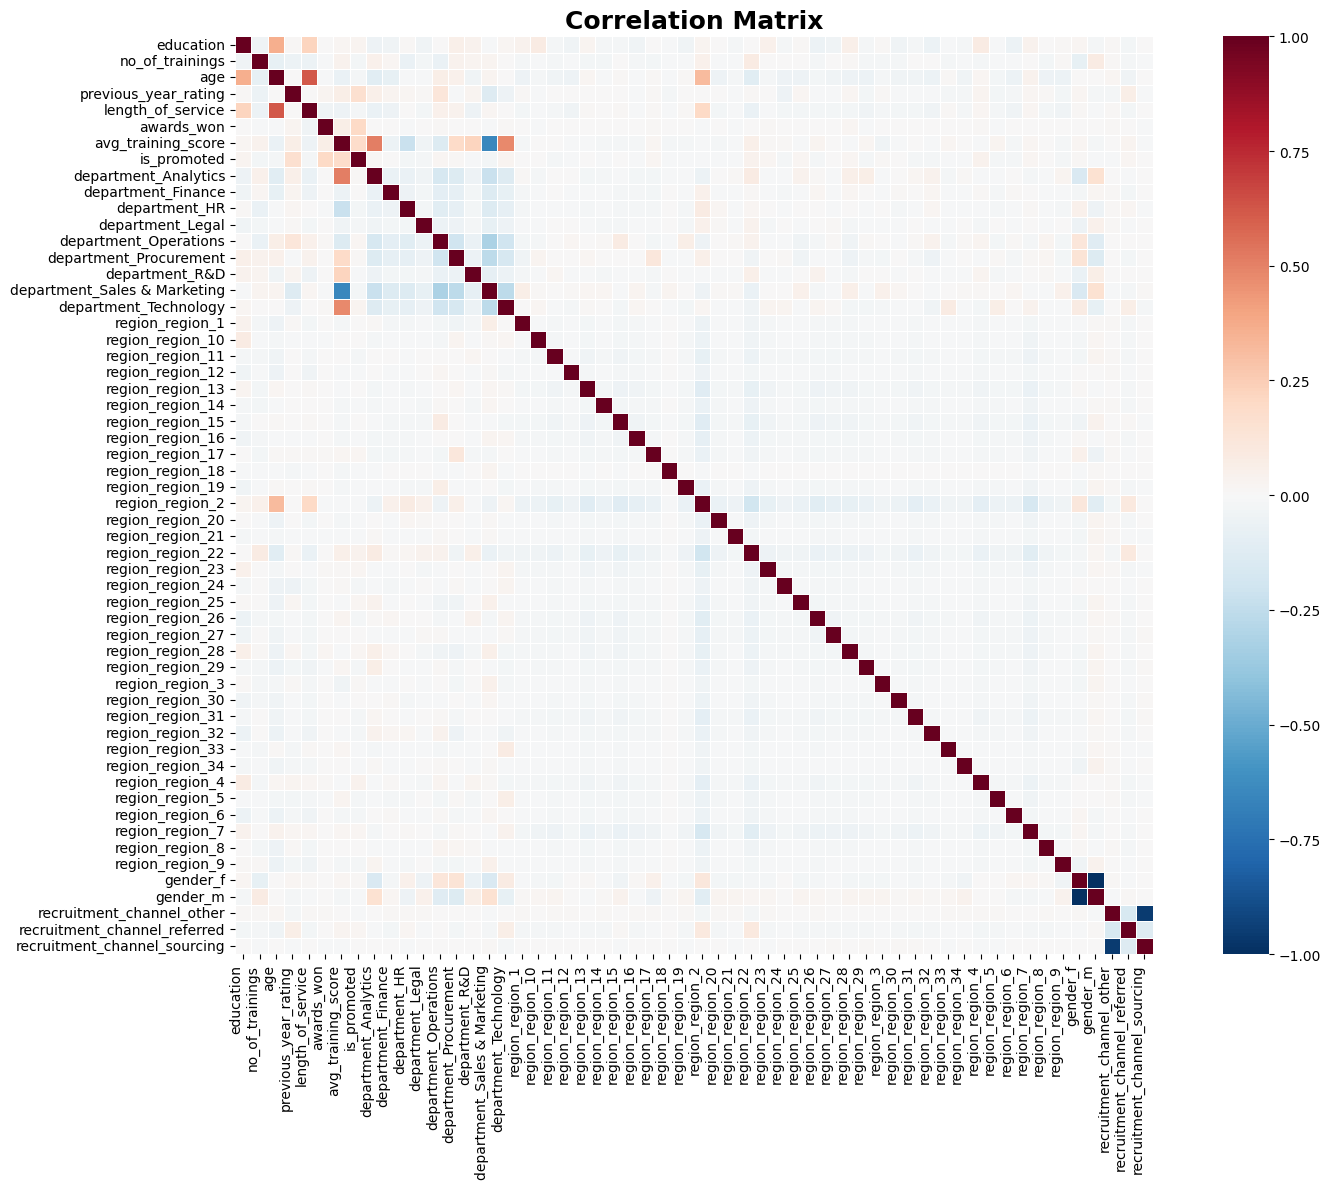

In [ ]:
# Matriz de correlación
corr_matrix = data_pre.drop('employee_id', axis=1).corr()

fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix.round(2), cmap='RdBu_r',
            ax=ax, annot_kws={"size": 4}, square=True, linewidths=0.5)
ax.set_title('Correlation Matrix', fontweight='bold', fontsize = 18)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

plt.show()

Lo primero que observamos es que la variable objetivo esta muy poco correlacionada con la mayoría de columnas del dataset, lo que nos indica que la tarea puede ser complicada con los datos disponibles. Por otro lado vemos que las columnas generadas para cada región no aportan nada de información con respecto a la variable objetivo para la cantidad que son, por lo que se va a probar a entrenar el modelo tanto sin ellas como con ellas para ver si la reducción de dimensionalidad mejora el rendimiento. Por otro lado hay dos pares de variables codificadas mediante one-hot encoding (gender_f - gender_m y recruitment_channel_other - recruitment_channel_sourcing) casi totalmente correlacionadas negativamente (es decir, cuando una está presente en una instancia, la otra no) lo cual nos indica que es información que podría ser redundante.

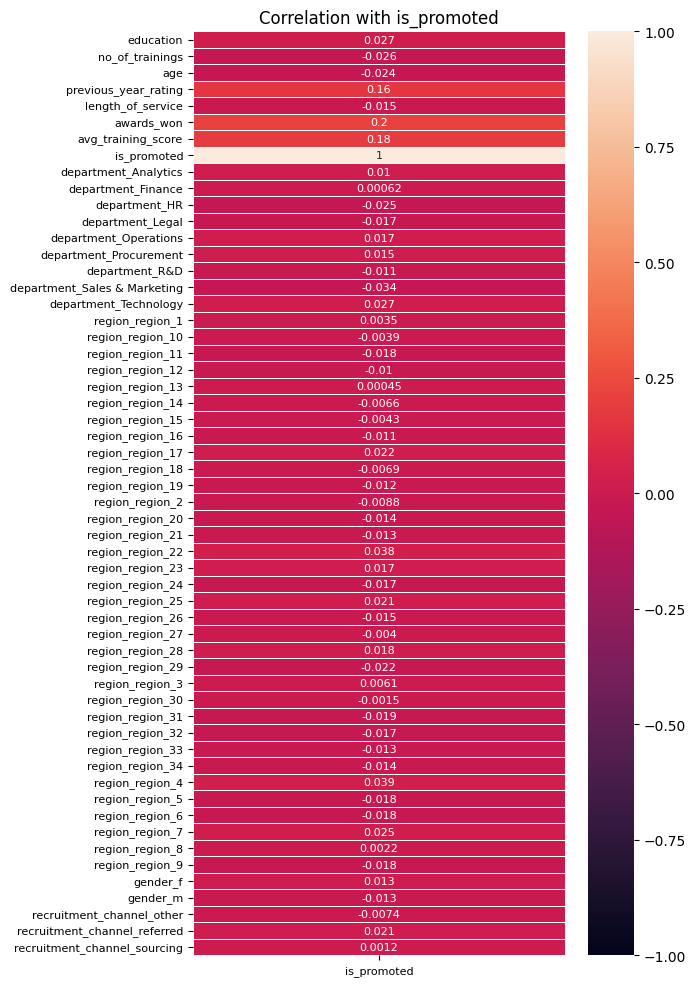

In [ ]:
plt.figure(figsize=(6, 12))
plt.title('Correlation with is_promoted')
ax = sns.heatmap(data_pre.drop('employee_id', axis=1).corr()[['is_promoted']], annot=True, vmin=-1, vmax=1, annot_kws={'fontsize' : 8 }, linewidths=0.5, linecolor='white')
ax.tick_params(labelsize=8)

In [ ]:
top10_corr = abs(data_pre.drop('employee_id', axis=1).corr()['is_promoted']).sort_values(ascending=False)[:10]
top10_corr

is_promoted                     1.000000
awards_won                      0.199343
avg_training_score              0.182750
previous_year_rating            0.160455
region_region_4                 0.039002
region_region_22                0.037552
department_Sales & Marketing    0.033977
department_Technology           0.027058
education                       0.026700
no_of_trainings                 0.025955
Name: is_promoted, dtype: float64

Observamos que las únicas variables relativamente correlacionadas con la variable objetivo son awards_won, avg_training_score y previous_year_rating. 

In [ ]:
top10_corr = abs(data_pre.drop('employee_id', axis=1).corr()['is_promoted']).sort_values(ascending=True)[:20]
top10_corr

region_region_13                0.000448
department_Finance              0.000620
recruitment_channel_sourcing    0.001200
region_region_30                0.001465
region_region_8                 0.002236
region_region_1                 0.003465
region_region_10                0.003876
region_region_27                0.004043
region_region_15                0.004250
region_region_3                 0.006074
region_region_14                0.006563
region_region_18                0.006909
recruitment_channel_other       0.007351
region_region_2                 0.008808
region_region_12                0.010267
department_Analytics            0.010278
region_region_16                0.011060
department_R&D                  0.011302
region_region_19                0.011890
region_region_33                0.012825
Name: is_promoted, dtype: float64

In [ ]:
data_pre.drop('employee_id', axis=1).corr()['recruitment_channel_other'][-3:]

recruitment_channel_other       1.000000
recruitment_channel_referred   -0.163951
recruitment_channel_sourcing   -0.957987
Name: recruitment_channel_other, dtype: float64

Como vemos la relación entre recruitment_channel_other y recruitment_channel_sourcing no es absoluta por lo que no se va a eliminar ninguna de las columnas. Por otro lado este sí es el caso del par de variables gender_f y gender_m como era de esperar, por lo que se va a eliminar una de las dos.

In [ ]:
data_pre.drop('gender_f', axis=1, inplace = True)

In [ ]:
#Creamos dataset con columnas de las regiones
data_reg = data_pre
data_reg.shape

(46380, 56)

In [ ]:
#Creamos dataset sin columnas de las regiones
data_no_reg = data_pre[data_pre.columns.drop(list(data_pre.filter(regex='region')))]
data_no_reg.shape

(46380, 22)

In [ ]:
# Cambiar según el dataset que se quiera utilizar
data_act = data_no_reg

Se ha decidido utilizar el dataset sin regiones ya que los modelos (sobre todo la regresión) se podían ver muy afectados por la dimensionalidad.

In [ ]:
X = data_act.drop(['is_promoted'], axis=1)
y = data_act['is_promoted']

<a name="escal"></a>
## Escalado de los datos

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, stratify = y, random_state = 100)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, stratify=y_rem, random_state = 100)
X_train

,employee_id,education,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_Analytics,department_Finance,...,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
41678,66881,2,1,28,3.0,2,0,51.0,0,0,...,0,0,0,0,1,0,1,0,0,1
24714,61523,2,1,35,4.0,7,0,48.0,0,0,...,0,0,0,0,1,0,1,0,0,1
23591,4024,2,1,27,5.0,2,0,85.0,1,0,...,0,0,0,0,0,0,1,1,0,0
5025,38367,3,2,39,4.0,11,0,71.0,0,0,...,0,1,0,0,0,0,1,0,0,1
7389,29424,3,1,38,5.0,7,0,75.0,0,0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11959,77323,2,1,37,5.0,11,0,60.0,0,1,...,0,0,0,0,0,0,1,0,0,1
37687,56891,2,1,31,5.0,4,0,84.0,1,0,...,0,0,0,0,0,0,1,1,0,0
51763,6382,2,1,54,3.0,16,0,80.0,0,0,...,0,0,0,0,0,1,1,0,0,1
5651,40131,2,1,26,3.0,2,0,84.0,1,0,...,0,0,0,0,0,0,1,0,0,1


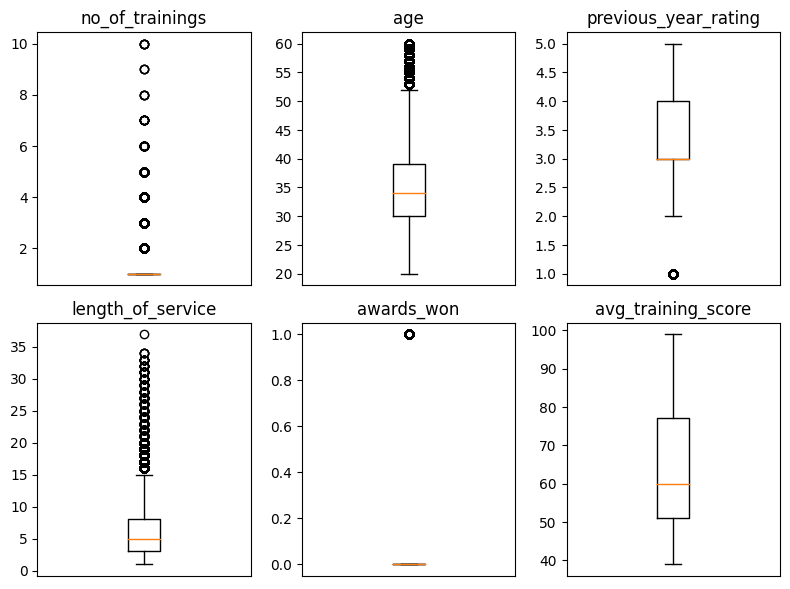

In [ ]:
columns = X.columns[2:8]
num_plots = len(columns)

fig, axes = plt.subplots(2, 3, figsize=(8, 6))
axes = axes.flatten()

for i, column in enumerate(columns):
    ax = axes[i]
    ax.boxplot(X[column])
    ax.set_title(column)
    ax.set_xticks([])
plt.tight_layout()

plt.show()

En estas gráficas se pueden observar la detección de outliers usando percentiles. Sin embargo ninguno de los marcados como atípicos (círculos) son realmente valores fuera de lo normal:
- no_trainings: Marca como atípico cualquier valor que no sea 0. Esto nos indica que la inmensa mayoría de los empleados tienen 0 no_trainings, pero hay varios (se puede observar según la intensidad del círculo) que tienen otros valores.
- age: Se puede apreciar que los valores que marca como atípicos están muy cerca de los normales y se encuentran entre 50 y 60, valores factibles para la variable edad.
- previous_year_rating: Marca como atípicos los que tienen un valor de 1 mientras que la mayoría tienen entre 2 y 5. El rating parece tener una escala del 1 al 5 por lo que los valores de 1 no deberían ser considerados outliers.
- length_of_service: Se puede argumentar igual que en el caso de la edad. Son valores muy continuos excepto para el que tiene un valor por encima de 35 que es un caso particular de un empleado que lleva mucho tiempo en la empresa. A pesar de ello es un caso perfectamente factible y no demasiado alejado de los demás.
- awards_won: Se trata de una variable binaria por lo que ningún valor es realmente atípico. Que considere a los que tienen un valor de 1 como atípicos nos indica que la mayoría de ellos tienen 0 premios ganados, pero no por esto hemos de descartar estos casos, ya que además es una de las variables más relacionadas con la variable objetivo.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop('employee_id', axis = 1))
X_valid_scaled = scaler.transform(X_valid.drop('employee_id', axis = 1))
X_test_scaled = scaler.transform(X_test.drop('employee_id', axis = 1))

<a name="prep"></a>
## Preparación de datasets finales

In [ ]:
df_train = pd.DataFrame(X_train_scaled, columns = X.drop('employee_id', axis = 1).columns)
df_train.index = X_train.index
df_train['is_promoted'] = y_train
df_train.to_csv('/content/drive/MyDrive/AA/PFinal/train.csv')

df_valid = pd.DataFrame(X_valid_scaled, columns = X.drop('employee_id', axis = 1).columns)
df_valid.index = X_valid.index
df_valid['is_promoted'] = y_valid
df_valid.to_csv('/content/drive/MyDrive/AA/PFinal/valid.csv')

df_test = pd.DataFrame(X_test_scaled, columns = X.drop('employee_id', axis = 1).columns)
df_test.index = X_test.index
df_test['is_promoted'] = y_test
df_test.to_csv('/content/drive/MyDrive/AA/PFinal/test.csv')

In [ ]:
df_train

,education,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_Analytics,department_Finance,department_HR,...,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,is_promoted
41678,-0.623475,-0.422793,-1.005549,-0.262994,-1.025403,-0.151824,-0.964044,-0.336598,-0.209684,-0.215136,...,-0.493895,-0.406904,-0.140007,1.538628,-0.404080,0.655359,-1.123256,-0.147812,1.173300,0
24714,-0.623475,-0.422793,-0.075481,0.532507,0.164474,-0.151824,-1.186938,-0.336598,-0.209684,-0.215136,...,-0.493895,-0.406904,-0.140007,1.538628,-0.404080,0.655359,-1.123256,-0.147812,1.173300,0
23591,-0.623475,-0.422793,-1.138416,1.328008,-1.025403,-0.151824,1.562079,2.970904,-0.209684,-0.215136,...,-0.493895,-0.406904,-0.140007,-0.649930,-0.404080,0.655359,0.890269,-0.147812,-0.852297,0
5025,1.481348,1.241820,0.455986,0.532507,1.116376,-0.151824,0.521910,-0.336598,-0.209684,-0.215136,...,2.024723,-0.406904,-0.140007,-0.649930,-0.404080,0.655359,-1.123256,-0.147812,1.173300,1
7389,1.481348,-0.422793,0.323119,1.328008,0.164474,-0.151824,0.819101,-0.336598,-0.209684,-0.215136,...,2.024723,-0.406904,-0.140007,-0.649930,-0.404080,0.655359,0.890269,-0.147812,-0.852297,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11959,-0.623475,-0.422793,0.190252,1.328008,1.116376,-0.151824,-0.295365,-0.336598,4.769070,-0.215136,...,-0.493895,-0.406904,-0.140007,-0.649930,-0.404080,0.655359,-1.123256,-0.147812,1.173300,0
37687,-0.623475,-0.422793,-0.606949,1.328008,-0.549452,-0.151824,1.487781,2.970904,-0.209684,-0.215136,...,-0.493895,-0.406904,-0.140007,-0.649930,-0.404080,0.655359,0.890269,-0.147812,-0.852297,0
51763,-0.623475,-0.422793,2.448989,-0.262994,2.306253,-0.151824,1.190590,-0.336598,-0.209684,-0.215136,...,-0.493895,-0.406904,-0.140007,-0.649930,2.474757,0.655359,-1.123256,-0.147812,1.173300,0
5651,-0.623475,-0.422793,-1.271283,-0.262994,-1.025403,-0.151824,1.487781,2.970904,-0.209684,-0.215136,...,-0.493895,-0.406904,-0.140007,-0.649930,-0.404080,0.655359,-1.123256,-0.147812,1.173300,0


<a name="bib"></a>
# Bibliografía

- Apuntes real world data: https://cvmdp.ucm.es/moodle/mod/resource/view.php?id=2430459
- Notebook de Kaggle: https://www.kaggle.com/code/muhammadimran112233/employee-promotion-end-to-end-solution

